## Multilayer Perceptron (MLP) based on TensorFlow

Multi-class classification problem - using a MLP with configurable number of hidden neurons - with a configurable number of classes (up to 10). It selects them from the (Fashion-)MNIST dataset, splits it up into a train and test part, does normalisation and then trains a classifier using softmax.

Both datasets consist of images with 28x28 = 784 pixel each. The features refer to these pixel values of the images.

You can choose MNIST or Fashion-MNIST data in cell [2]

We use the Keras TensorFlow API in particular the Sequential model, which provides all required layer types [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras).

In [1]:
import torch
import torchvision
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard 
import numpy as np
import matplotlib.pyplot as plt
import time


In [60]:
#only at first execution data is downloaded, because it is saved in subfolder ../week1/data; 
#note the relative path to ../week1/data to avoid multiple downloads
data_set = 'CIFAR10'
data_root = "./data"
if data_set == 'MNIST':
    training_data = torchvision.datasets.MNIST(
        root="./data",
        train=True,
        download=True,
        transform=torchvision.transforms.ToTensor()
    )

    test_data = torchvision.datasets.MNIST(
        root="./data",
        train=False,
        download=True,
        transform=torchvision.transforms.ToTensor()
    )    

    #labels for MNIST (just for compatibility reasons)
    labels_map = {
        0: "Zero",
        1: "One",
        2: "Two",
        3: "Three",
        4: "Four",
        5: "Five",
        6: "Six",
        7: "Seven",
        8: "Eight",
        9: "Nine",
    }
elif data_set == 'CIFAR10':
    training_data = torchvision.datasets.CIFAR10(
        root=data_root,
        train=True,
        download=True,
        transform=torchvision.transforms.ToTensor()
    )

    test_data = torchvision.datasets.CIFAR10(
        root=data_root,
        train=False,
        download=True,
        transform=torchvision.transforms.ToTensor()
    )

    # Labels for CIFAR10
    labels_map = {
        0: "Airplane",
        1: "Automobile",
        2: "Bird",
        3: "Cat",
        4: "Deer",
        5: "Dog",
        6: "Frog",
        7: "Horse",
        8: "Ship",
        9: "Truck",
    }
else:
    training_data = torchvision.datasets.FashionMNIST(
        root="./data",
        train=True,
        download=True,
        transform=torchvision.transforms.ToTensor()
    )

    test_data = torchvision.datasets.FashionMNIST(
        root="./data",
        train=False,
        download=True,
        transform=torchvision.transforms.ToTensor()
    )

    #labels for FashionMNIST
    labels_map = {
        0: "T-Shirt",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    }

100%|██████████| 170498071/170498071 [00:14<00:00, 11400109.87it/s]


Extracting ../week1/data\cifar-10-python.tar.gz to ../week1/data
Files already downloaded and verified


In [65]:
type(training_data.data)

numpy.ndarray

In [72]:
#tensorflow works with numpy array -> convert to numpy array (originally it is a torch.tensor)

x = training_data.data
x = np.append(x, test_data.data,0)

y = training_data.targets
y = np.append(y, test_data.targets)

print(x.shape)
print(y.shape)

(60000, 32, 32, 3)
(60000,)


(32, 32, 3)


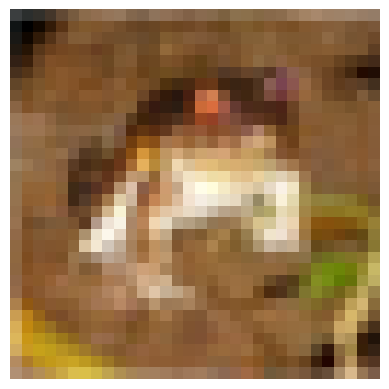

In [80]:
def plot_img(img):
    print(img.shape)
    """
    plot a single mnist image
    """
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    ax.set_axis_off()
    
    
plot_img(x[0])

In [83]:
def plot_tiles(x_array, rows, cols=-1, fig_size=[10, 10]):
    digit_size = 32  # size of digit (width = height)
    channels = 3  # number of color channels

    # Use rows = cols as default
    if cols < 0:
        cols = rows

    if x_array.shape[0] < rows * cols:
        cols = int(x_array.shape[0] / rows)
        remain = np.mod(x_array.shape[0], rows)
        if 0 < remain:
            cols += 1
            # Adjust padding to account for color channels
            x_array = np.append(x_array, np.zeros((rows - remain, digit_size, digit_size, channels)), axis=0)

    # Initialize an empty array for the tiled image
    img = np.zeros((rows * digit_size, cols * digit_size, channels), dtype=x_array.dtype)

    for i in range(rows):
        for j in range(cols):
            if i * cols + j < x_array.shape[0]:
                img[i * digit_size:(i + 1) * digit_size, j * digit_size:(j + 1) * digit_size, :] = x_array[i * cols + j]

    fig = plt.figure(figsize=fig_size)
    ax = fig.subplots()
    ax.imshow(np.clip(img, 0, 1))  # Clip values to valid range
    ax.set_axis_off()

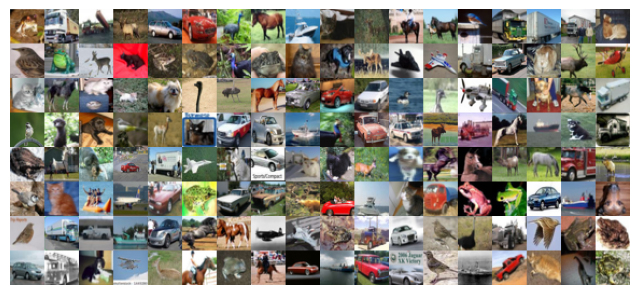

In [84]:
#append rows x cols tiles of images
rows = 8
cols = 18
#figure size can be set
fig_size = [8,8]
x = x.reshape(-1, 32, 32, 3) / 255.0
plot_tiles(x, rows, cols, fig_size)

Airplane


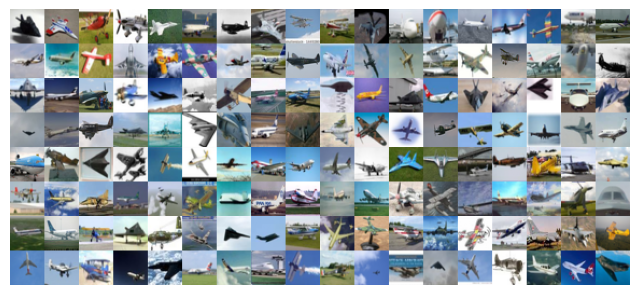

In [85]:
#choose a given class 0..9
digit  = 0

plot_tiles(x[y==digit], rows, cols, fig_size)
print(labels_map[digit])

In [86]:
#select the classes for your training and test set, select train and test split and to normalization
def prepare_data(classes, train_size=0.8, min_max_normalise=1, flatten=1):
    """
    prepare the data for training

    Arguments:
    classes -- list of classes to use for training (at least two classes must be given)
    train_size -- fraction of train image size
    min_max_normalise -- whether to do min-max-normalisation (1) or rescaling (0)
    flatten -- whether to flatten the 28x28 image to single row (=1); otherwise a new dimension is added at axis=1 (to be compatible with cnn)
    """

    if len(classes) < len(labels_map):
        for label in classes:
            print('labels chosen are: %r' % labels_map[label])

    ind_sel = np.isin(y, classes)
    x_sel = x[ind_sel,:].copy()
    y_sel = y[ind_sel].copy()
    
    #replace the labels such that they are in successive order
    for i0 in range(0,len(classes)):
        if i0 != classes[i0]:
            y_sel[y_sel == classes[i0]] = i0

    #we give y back as simple vector -> simplifies handling below
    #y_sel = np.reshape(y_sel, (-1,1))
    
    #do train and test split
    num_samples = x_sel.shape[0]
    max_train_ind = int(train_size*num_samples)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    x_train = x_sel[indices[:max_train_ind]]
    x_test = x_sel[indices[max_train_ind:]]
    
    y_train = y_sel[indices[:max_train_ind]]
    y_test = y_sel[indices[max_train_ind:]]

    #perform normalisation, take care of converting data type to float!
    xmax, xmin = np.max(x_train), np.min(x_train)
    
    if min_max_normalise:
        x_train = 2*(x_train.astype(float) - xmin) / (xmax - xmin) - 1
        x_test = 2*(x_test.astype(float) - xmin) / (xmax - xmin) - 1
    else:
        x_train = x_train.astype(float) / xmax 
        x_test = x_test.astype(float) / xmax 

    if flatten:
        m = x_train.shape[0]
        x_train = x_train.reshape([m,-1])
        m = x_test.shape[0]
        x_test = x_test.reshape([m,-1])
    else:
        x_train = np.expand_dims(x_train,1)
        x_test = np.expand_dims(x_test,1)

    #tensorflow requires onehot data
    y_train = one_hot(y_train, len(classes))
    
    return x_train, x_test, y_train, y_test


def one_hot(y, size_out):
        """
        construct onehot vector from set of labels
        """
        m = y.shape[0]
        one_hot = np.zeros((m, size_out), dtype=float)
        one_hot[np.arange(m), y] = 1

        return one_hot

### Class NeuralNetwork

This class constructs a Multilayer Perceptron with a configurable number of hidden layers. Cost function is CE. The method $propagate()$ returns the prediction $$ \hat{y}^{(i)}=h_\theta(\mathbf{x}^{(i)}) $$ on the input data (can be a n x 784 matrix of n images) and $back\_propagate()$ determines the gradients of the cost function with respect to the parameters (weights and bias for all layers) $$ \nabla_{\mathbf{\theta}} J(\mathbf{\theta}) $$
The method $gradient\_descend()$ finally does the correction of the parameters with a step in the negative gradient direction, weighted with the learning rate $$\alpha$$ for all layers.

In [91]:
class NeuralNetwork:
    """
    MLP class handling the layers and doing all propagation and back propagation steps
    all hidden layers are dense (with ReLU activation) and the last layer is softmax
    """
    def __init__(self, list_num_neurons, alpha):
        """
        constructor

        Arguments:
        list_num_neurons -- list of layer sizes including in- and output layer
        alpha -- learning rate (required because optimiser must be known to compile model)
        """
        self.model = tf.keras.Sequential()
        
        #we require a flatten tensor
        self.model.add(tf.keras.layers.Flatten(input_shape=(1, 32, 32, 3)))
        
        for i0 in range(len(list_num_neurons)-1):
            self.model.add(tf.keras.layers.Dense(list_num_neurons[i0], activation='sigmoid'))
            
        #finally add softmax layer
        self.model.add(tf.keras.layers.Dense(list_num_neurons[-1], activation='softmax'))

        print(self.model.summary())
                         
        #choose the optimiser
        optimizer = tf.keras.optimizers.SGD(learning_rate=alpha)
        
        #wrap the model to a tf.function (unless run_eagerly=True)
        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
         
        
    def optimise(self, data, epochs, valid_size=0.2, batch_size=16, debug=0, call_backs=None):
        """
        performs epochs number of gradient descend steps and appends result to output array

        Arguments:
        data -- dictionary with NORMALISED data
        epochs -- number of epochs
        valid_size -- fraction of data used for validation
        batch_size -- size of batches (1 = SGD, 1 < .. < n = mini-batch)
        debug -- output: 0 = silent, 1 = progress bar, 2 = one line per epoch
        call_backs -- use to send output to tensorboard
        """
         
        #now start training (you can choose the train/validation set split)
        self.history = self.model.fit(data['x_train'], data['y_train'], 
                            validation_split=valid_size,   
                            batch_size=batch_size, epochs=epochs,
                            callbacks=call_backs, verbose = debug)
         

In [92]:
def plot_error(nn_instance):
    """
    analyse error as function of epochs

    Arguments:
    nn_instance -- NeuralNetwork class to plot
    """
    epochs = np.arange(len(NNet.history.history['accuracy']))
    train_acc = nn_instance.history.history['accuracy']
    val_acc = nn_instance.history.history['val_accuracy']

    plt.plot(epochs, train_acc, label="train")
    plt.plot(epochs, val_acc, label="validation")
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    xmax = epochs[-1]
    ymin = min(min(train_acc),min(val_acc))
    ymax = 1
    plt.axis([0,xmax,ymin,ymax])
    plt.legend()
    plt.show() 

In [93]:
def plot_cost(nn_instance):
    """
    analyse cost as function of epochs

    Arguments:
    nn_instance -- NeuralNetwork class to plot
    """
    epochs = np.arange(len(nn_instance.history.history['loss']))
    train_costs = nn_instance.history.history['loss']
    val_costs = nn_instance.history.history['val_loss']

    plt.semilogy(epochs, train_costs, label="train")
    plt.semilogy(epochs, val_costs, label="validation")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    xmax = epochs[-1]
    ymin = 1e-2
    ymax = 2
    plt.axis([0,xmax,ymin,ymax])

    plt.legend()
    plt.show() 

### Sample execution of Neural Network

The cell below shows how to use the class NeuralNetwork and how to perform the optimisation. The training and test data is given as dictionary in the call to the method $optimise()$. The classes (from 2 to 10) can be chosen via the `classes` list. 

*This version is used without TensorBoard*

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 3072)              0         
                                                                 
 dense_6 (Dense)             (None, 100)               307300    
                                                                 
 dense_7 (Dense)             (None, 10)                1010      
                                                                 
Total params: 308310 (1.18 MB)
Trainable params: 308310 (1.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/20
1200/1200 - 5s - loss: 2.0162 - accuracy: 0.2998 - val_loss: 1.8980 - val_accuracy: 0.3504 - 5s/epoch - 4ms/step
Epoch 2/20
1200/1200 - 4s - loss: 1.8625 - accuracy: 0.3576 - val_loss: 1.8341 - val_accuracy: 0.3684 - 4s/epoch - 3ms/step
Epoch 3/20
1200/1200 - 4s - l

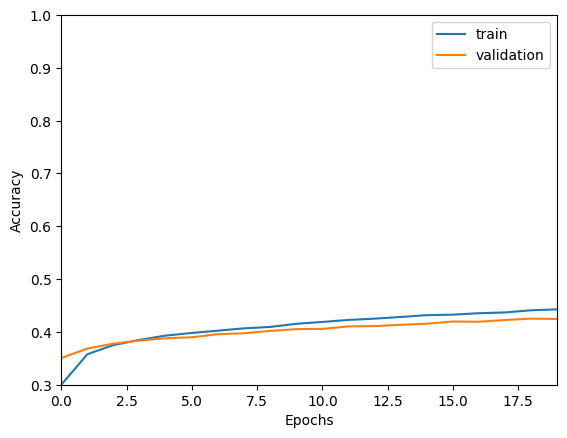

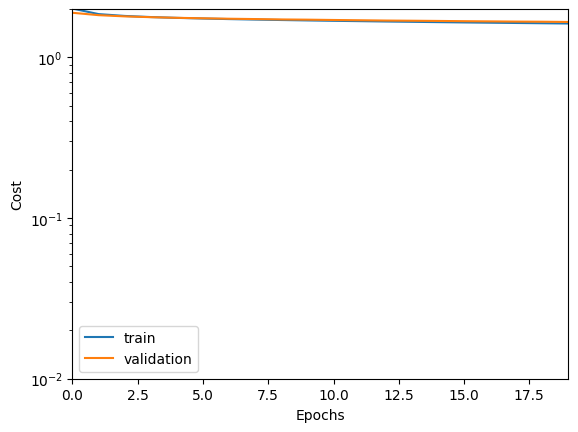

In [102]:
#choose the categories
classes = [0,1,2,3,4,5,6,7,8,9]

#y_train is of type onehot (y_test not!)
x_train, x_test, y_train, y_test = prepare_data(classes, train_size=0.8, min_max_normalise=1, flatten=0)

#data is arranged as dictionary with quick access through respective keys
#tensorflow does the split in train and validate
data = {'x_train' : x_train, 'y_train' : y_train}

#choose the hyperparameters you want to use for the initialisation
size_out = len(classes)
list_num_neurons = [100, size_out]; 
learning_rate = 0.005
NNet = NeuralNetwork(list_num_neurons, learning_rate)

#choose the hyperparameters you want to use for training
epochs = 20
batchsize = 32
NNet.optimise(data, epochs, valid_size=0.2, batch_size=batchsize, debug=2)

plot_error(NNet)
plot_cost(NNet)

375/375 [==============================] - 1s 1ms/step
test error rate: 57.82 % out of 12000
(6938, 1, 32, 32, 3)
[[0 9 7 3 7 5 8 7]
 [2 7 5 7 1 1 3 3]
 [3 7 1 2 3 5 3 2]
 [3 0 5 4 0 0 0 3]
 [1 0 8 3 0 5 2 1]
 [9 9 7 3 2 9 3 2]
 [4 2 7 3 7 7 5 8]]


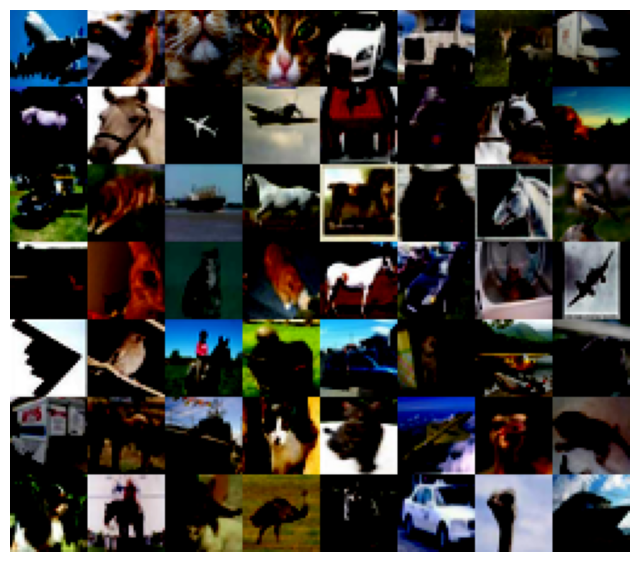

In [103]:
#analyse false classified training or test images
y_pred = np.argmax(NNet.model.predict(x_test), axis=1)
false_classifications = x_test[(y_pred != y_test)]

print('test error rate: %.2f %% out of %d' % (100*false_classifications.shape[0]/y_pred.shape[0], y_pred.shape[0]))
print(false_classifications.shape)

#append rows x cols tiles of digits
rows = 7
cols = 8
#figure size can be set
fig_size = [8,8]

plot_tiles(false_classifications.reshape([-1,32,32, 3]), rows, cols, fig_size)

#print the correct labels (for FashionMNIST)
if rows*cols < false_classifications.shape[0]:
    false_classifications_y = y_test[y_pred != y_test][:rows*cols]
else:
    false_classifications_y = np.append(y_test[y_pred != y_test], np.ones(rows*cols - false_classifications.shape[0])*-1)
print(false_classifications_y.reshape([cols,rows]).T)

we have 100 weight vectors in layer [0]
choose a suitable combination of rows and cols below to plot them


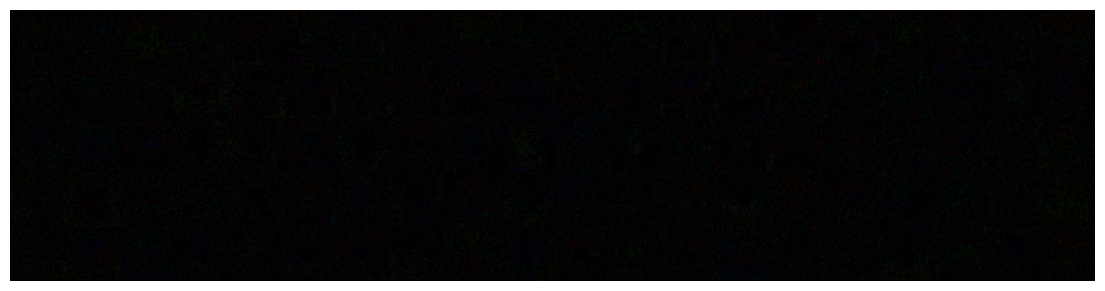

In [104]:
#visualise weights of the first layer

print('we have %r weight vectors in layer [0]' % NNet.model.layers[1].get_weights()[0].shape[1])
print('choose a suitable combination of rows and cols below to plot them')

rows = 5
cols = 20
#figure size can be set
fig_size = [14,6]

plot_tiles(NNet.model.layers[1].get_weights()[0].T.reshape([-1,32,32, 3]), rows, cols, fig_size)

### Sample execution of Neural Network

The cell below shows how to use the class NeuralNetwork and how to perform the optimisation. The training and test data is given as dictionary in the call to the method $optimise()$. The classes (from 2 to 10) can be chosen via the `classes` list. 

*This version is used with TensorBoard*

In [106]:
#clear everything
tf.keras.backend.clear_session()

#you may have to delete the model to start from scratch
#del model

#output is written to the folder with name defined below
name = 'ciphar10_test'

tensorboard = TensorBoard(
        log_dir='./tensorboard/' + name + '/', 
        update_freq='epoch', write_graph=True,
        histogram_freq=1)


#choose the categories
classes = [0,1,2,3,4,5,6,7,8,9]

#y_train is of type onehot (y_test not!)
x_train, x_test, y_train, y_test = prepare_data(classes, train_size=0.8, min_max_normalise=1, flatten=0)

#data is arranged as dictionary with quick access through respective keys
#tensorflow does the split in train and validate
data = {'x_train' : x_train, 'y_train' : y_train}

#choose the hyperparameters you want to use for the initialisation
size_out = len(classes)
list_num_neurons = [100, size_out]; 
learning_rate = 0.05
NNet = NeuralNetwork(list_num_neurons, learning_rate)

#choose the hyperparameters you want to use for training
epochs = 10
batchsize = 16
NNet.optimise(data, epochs, valid_size=0.2, batch_size=batchsize, debug=0, call_backs=[tensorboard])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 100)               307300    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 308310 (1.18 MB)
Trainable params: 308310 (1.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Here is the result of the tensorboard : 

![](images/tensoboard_tensorflow.png)


Only did the training for 10 epochs, because it did converge very fast. The result is not very good, but it is a good start to take in hand the tensorboard and the tensorflow library.